# Subtask 3
# Hierarchical Clustering

Requirements:

- Python 3.13.1
- numpy
- pandas
- scikit-learn
- matplotlib
- scipy

In [1]:
import logging
from typing import List, Optional, Tuple, Dict

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

## Preprocessing
Load the data and preprocess it. Drop features we dont need. Since we are working with mixed-type data, we need to encode features that are not continuous numeric. Also, missing values need to be imputated.

In [2]:
df = pd.read_csv("../dataset/tracks.csv")
df.head()

,id,id_artist,name_artist,full_title,title,featured_artists,primary_artist,language,album,stats_pageviews,...,album_type,disc_number,track_number,duration_ms,explicit,popularity,album_image,id_album,lyrics,modified_popularity
0,TR934808,ART04205421,Rosa Chemical,​polka 2 :-/ by Rosa Chemical (Ft. Ernia & Guè),​polka 2 :-/,"Ernia, Guè",Rosa Chemical,pl,FOREVER AND EVER,196033.0,...,album,1.0,3.0,207761.0,True,46.0,https://i.scdn.co/image/ab67616d0000b2736d5e14...,ALB115557,"Oplà, ah\nBdope, chiama due b—\n\nMi candidere...",False
1,TR760029,ART04205421,Rosa Chemical,POLKA by Rosa Chemical (Ft. Thelonious B.),POLKA,Thelonious B.,Rosa Chemical,en,FOREVER AND EVER,164450.0,...,album,1.0,3.0,207761.0,True,46.0,https://i.scdn.co/image/ab67616d0000b2736d5e14...,ALB115557,"Greg Willen, non dormire\n(Brr-poh)\n\nT-T-Tro...",False
2,TR916821,ART04205421,Rosa Chemical,​britney ;-) by Rosa Chemical (Ft. MamboLosco ...,​britney ;-),"MamboLosco, RADICAL",Rosa Chemical,en,FOREVER AND EVER,58313.0,...,album,1.0,1.0,193544.0,True,39.0,https://i.scdn.co/image/ab67616d0000b2736d5e14...,ALB115557,"Mothz\nYeah, yeah, yeah-yeah\nBdope, chiama du...",False
3,TR480968,ART04205421,Rosa Chemical,CEO by Rosa Chemical (Ft. Taxi B),CEO,Taxi B,Rosa Chemical,it,OKAY OKAY !! - EP,39890.0,...,single,1.0,2.0,169000.0,True,47.0,https://i.scdn.co/image/ab67616d0000b27367c03d...,ALB730959,Designer sui vestiti penso di essere un outlet...,False
4,TR585039,ART04205421,Rosa Chemical,LONDRA by Rosa Chemical (Ft. Rkomi),LONDRA,Rkomi,Rosa Chemical,en,FOREVER AND EVER,35432.0,...,album,1.0,8.0,194779.0,True,41.0,https://i.scdn.co/image/ab67616d0000b273fcdb60...,ALB436151,"Bdope (Yeah)\n\nVuole solo me, non fare la gel...",False


### Drop Irrelevant Features
Many columns such as names or unique identifiers are not relevant for clustering. We drop them.

In [3]:
cols_to_drop = ["id",
    "id_artist",
    "name_artist",
    "full_title",
    "title",
    "album_name",
    "album_release_date",
    "id_album",
    "album_image",
    "lyrics",
    "swear_IT_words",
    "swear_EN_words",
    "month",
    "day",
    "disc_number",
    "track_number"
]

df = df.drop(columns=cols_to_drop)

In [4]:
# Relevant preprocessing functions

def clean(df: pd.DataFrame) -> pd.DataFrame:
    # Replace empty cells (or ?) with NA
    df = df.replace(r"^\?|\s+$", pd.NA, regex=True)

    # Columns with whitespace (or ?) values are infered as string type but could be numeric
    for col in df.select_dtypes(exclude=[np.number, np.bool_]).columns:
        # Exclude booleans
        if df[col].nunique() > 2:
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                logging.debug("Could not convert column %s to numeric dtype", col)

    # Integer columns with missing values automatically get converted to float columns
    # We want to convert back to integer to allow for better column classification (num/cat)
    for col in df.select_dtypes(include=np.floating):
        if np.all(df[col].fillna(0) % 1 == 0):
            df[col] = df[col].astype("Int64")

    # Turn object columns into string columns (causes issues with stepmix)
    for col in df.select_dtypes(include=object).columns:
        df[col] = df[col].astype(str)

    return df


def classify_cols(
    df: pd.DataFrame,
    bool_cols: bool = False,
) -> Tuple:
    # All floating point columns are considered numeric
    num_cols: List[str] = list(df.select_dtypes(include=np.inexact).columns)
    cat_cols: List[str] = []
    bool_cols_: List[str] = list(df.select_dtypes(include=np.bool_).columns) if bool_cols else []

    remaining_cols = df.columns.difference(num_cols + bool_cols_)

    if bool_cols:
        for col in remaining_cols:
            if df[col].nunique() <= 2:
                bool_cols_.append(col)
                remaining_cols = remaining_cols.drop(col)

    # Integer columns with more than 50 unique values are considered numeric
    for col in df[remaining_cols].select_dtypes(include=np.integer).columns:
        if df[col].nunique() >= 50:
            num_cols.append(col)
            remaining_cols = remaining_cols.drop(col)

    # All other columns are considered categorical
    cat_cols = list(remaining_cols)

    logging.info("Num cols: %s", num_cols)
    logging.info("Cat cols: %s", cat_cols)
    logging.info("Bool cols: %s", bool_cols_)
    if bool_cols:
        return num_cols, cat_cols, bool_cols_
    return num_cols, cat_cols


def scale_cols(
    df: pd.DataFrame,
    num_cols: Optional[List[str]],
    cat_cols: Optional[List[str]],
    bool_cols: Optional[List[str]] = None,
) -> pd.DataFrame:
    df = df.copy(deep=True)
    if num_cols:
        df[num_cols] = StandardScaler().fit_transform(df[num_cols])
    if cat_cols:
        df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)
    if bool_cols:
        df[bool_cols] = df[bool_cols].apply(LabelEncoder().fit_transform)
    return df


def imputate_na(
    df: pd.DataFrame,
    num_cols: Optional[List[str]],
    cat_cols: Optional[List[str]],
    bool_cols: Optional[List[str]] = None,
) -> pd.DataFrame:
    if num_cols:
        # imputate numeric features
        for col in num_cols:
            df[col] = df[col].fillna(round(df[col].median()))
    if cat_cols is None:
        cat_cols = []
    if bool_cols is None:
        bool_cols = []
    # add "missing" category for categorical features
    for col in cat_cols + bool_cols:
        df[col] = df[col].astype(str)
        df[col] = df[col].fillna("<NA>")
    return df

### Cleaning, Imputating, Scaling and Labelling
Now execute the functions from above to return a dataframe we can use for computation.

In [5]:
# Save old dataframe for later
og_df = df.copy(deep=True)

df = clean(df)
num_cols, cat_cols, bool_cols = classify_cols(df, bool_cols=True)
df = imputate_na(df, num_cols, cat_cols, bool_cols)
df = scale_cols(df, num_cols, cat_cols, bool_cols)

df.head()

,featured_artists,primary_artist,language,album,stats_pageviews,swear_IT,swear_EN,year,n_sentences,n_tokens,...,zcr,flatness,spectral_complexity,pitch,loudness,album_type,duration_ms,explicit,popularity,modified_popularity
0,485,82,24,240,4.382687,5,34,104,1.730216,1.986653,...,2.245231,-0.371348,-0.201151,0.144966,-0.737947,0,0.048662,1,82,0
1,1579,82,9,240,3.566031,43,4,103,-0.137659,0.854572,...,2.940790,-1.709861,0.202091,-0.954668,-0.321424,0,0.048662,1,82,0
2,1004,82,9,240,0.821598,8,4,104,1.161733,1.252719,...,0.918816,-0.700716,-0.051288,0.599459,0.606187,0,-0.112995,1,72,0
3,1555,82,17,555,0.345227,42,21,102,-0.909173,-0.550936,...,-1.043848,0.142831,-1.557827,1.912401,-0.431909,3,-0.392077,1,83,0
4,1382,82,9,240,0.229954,1,0,103,-0.462507,-0.325479,...,0.352663,-0.033747,1.103381,-1.794887,0.128634,0,-0.098952,1,75,0


### Encoding
Now we use one-hot encoding to encode the categorical features. Boolean features only need encoding if they contain NaN or NA values (=missing values), otherwise they are left as is. To reduce the number of features, we only encode features that have more unique values than a threshhold. This will get rid of features with too many unique values, such as song lyrics. These features would add up to N new features to the dataset, which is not a good idea.

In [6]:
def one_hot_encode_feature(df: pd.DataFrame, feature_to_encode: str, weight: float = 1) -> pd.DataFrame:
    dummies = pd.get_dummies(df[feature_to_encode], dtype="int32", prefix=feature_to_encode)
    dummies *= weight
    result_df = pd.concat([df, dummies], axis=1)
    return result_df.drop(columns=feature_to_encode)


encoded_df = df.copy(deep=True)

for col in cat_cols + [col for col in bool_cols if encoded_df[col].nunique() > 2]:
    # Dont encode columns with too many unique values
    if encoded_df[col].nunique() > 50:
        logging.warning("Column %s has too many unique values, dropping", col)
        encoded_df = encoded_df.drop(columns=col)
    else:
        encoded_df = one_hot_encode_feature(encoded_df, col)

encoded_df.head()

,stats_pageviews,n_sentences,n_tokens,tokens_per_sent,char_per_tok,lexical_density,avg_token_per_clause,bpm,centroid,rolloff,...,swear_IT_34,swear_IT_35,swear_IT_36,swear_IT_37,swear_IT_38,swear_IT_39,swear_IT_40,swear_IT_41,swear_IT_42,swear_IT_43
0,4.382687,1.730216,1.986653,0.046638,0.261922,0.786870,0.009550,0.793368,1.642220,2.259997,...,0,0,0,0,0,0,0,0,0,0
1,3.566031,-0.137659,0.854572,0.598627,0.510317,1.792820,0.310083,0.570975,2.354421,3.112774,...,0,0,0,0,0,0,0,0,0,1
2,0.821598,1.161733,1.252719,-0.009536,0.047712,0.535180,0.029394,0.732070,1.558628,0.743616,...,0,0,0,0,0,0,0,0,0,0
3,0.345227,-0.909173,-0.550936,0.292905,-0.067872,0.227492,-0.089032,1.798812,-1.066151,-0.813071,...,0,0,0,0,0,0,0,0,1,0
4,0.229954,-0.462507,-0.325479,0.047721,-0.295177,-0.358439,0.028674,-0.307387,0.181037,0.135803,...,0,0,0,0,0,0,0,0,0,0


## Clustering
We can now cluster the songs using Hierarchical Clustering (Agglomerative Clustering).

### Hierarchical Clustering
Hierarchical clustering builds a hierarchy of clusters by either:
- **Agglomerative (bottom-up)**: Start with each point as its own cluster and merge the closest pairs iteratively
- **Divisive (top-down)**: Start with all points in one cluster and split recursively

We'll use agglomerative clustering with different linkage methods:
- **Ward**: Minimizes the variance of merged clusters (default)
- **Complete**: Uses maximum distances between all observations of the two sets
- **Average**: Uses average distances between all observations of the two sets
- **Single**: Uses minimum distances between all observations of the two sets

The clustering is run with different numbers of clusters (k from 2 to 10). Each time, the result is evaluated using:
- **Silhouette Score**: Measures how similar an object is to its own cluster compared to other clusters (higher is better)
- **Variance Ratio Criterion (Calinski-Harabasz)**: Ratio of between-cluster to within-cluster variance (higher is better)
- **Davies-Bouldin Index**: Average similarity between clusters (lower is better)

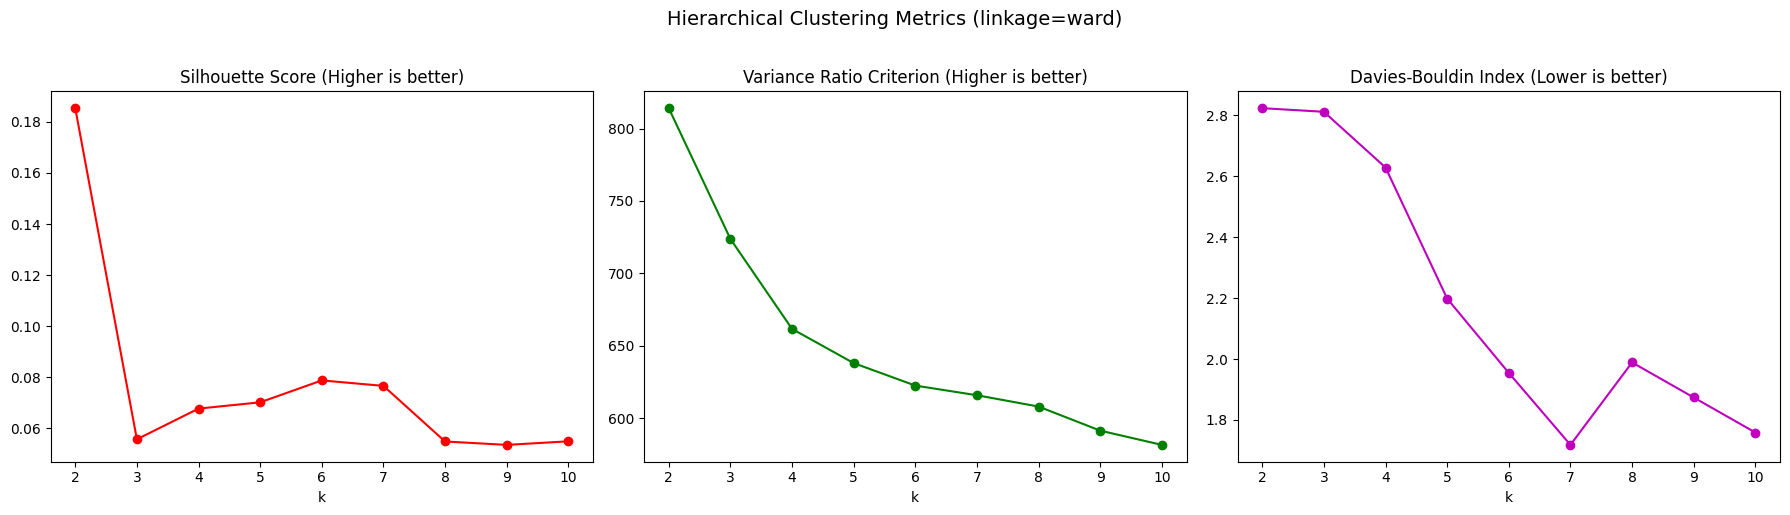

In [7]:
# Hierarchical clustering with different k values
metrics = {
    'silhouette': [],
    'vrc': [],  # Variance Ratio Criterion; Calinski, Harabasz
    'davies_bouldin': []
}
results = {}

linkage_method = 'ward'

for k in range(2, 11):
    hierarchical = AgglomerativeClustering(n_clusters=k, linkage=linkage_method)
    labels = hierarchical.fit_predict(encoded_df)
    results[k] = labels

    metrics['silhouette'].append(silhouette_score(encoded_df.values, labels))
    metrics['vrc'].append(calinski_harabasz_score(encoded_df.values, labels))
    metrics['davies_bouldin'].append(davies_bouldin_score(encoded_df.values, labels))

# Plot all metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
k_range = range(2, 11)

axes[0].plot(k_range, metrics['silhouette'], 'ro-')
axes[0].set_title('Silhouette Score (Higher is better)')
axes[0].set_xlabel('k')

axes[1].plot(k_range, metrics['vrc'], 'go-')
axes[1].set_title('Variance Ratio Criterion (Higher is better)')
axes[1].set_xlabel('k')

axes[2].plot(k_range, metrics['davies_bouldin'], 'mo-')
axes[2].set_title('Davies-Bouldin Index (Lower is better)')
axes[2].set_xlabel('k')

plt.suptitle(f'Hierarchical Clustering Metrics (linkage={linkage_method})', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Dendrogram
A dendrogram is a tree-like diagram that shows the hierarchical relationship between clusters. It helps visualize how clusters are merged at each step and can assist in determining the optimal number of clusters.

Note: For large datasets, we'll sample a subset of data points to make the dendrogram readable.

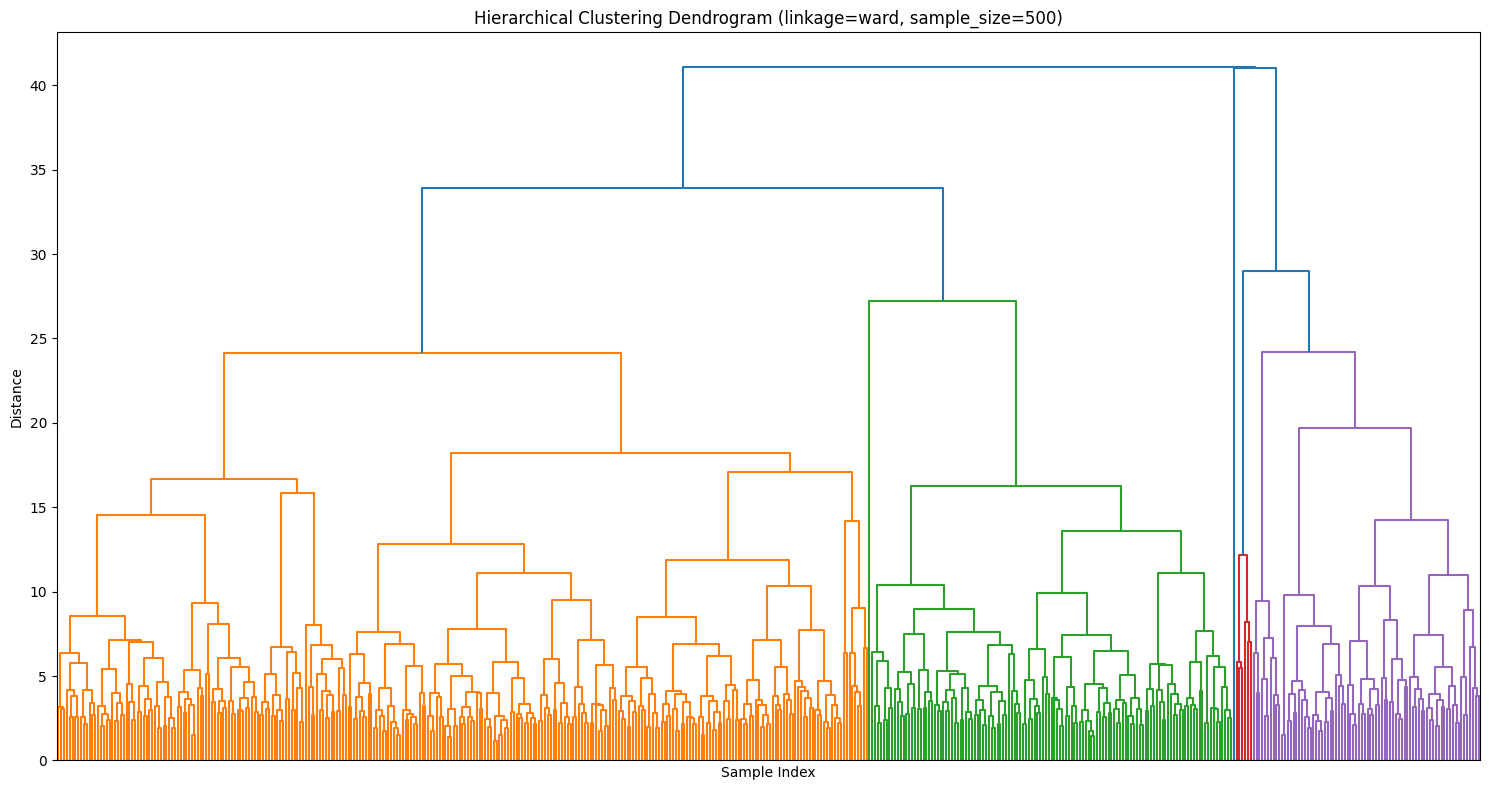

In [8]:
# Create dendrogram with a sample of the data for readability
sample_size = min(500, len(encoded_df))
sample_indices = np.random.choice(len(encoded_df), sample_size, replace=False)
sample_data = encoded_df.iloc[sample_indices]

# Compute linkage matrix
linkage_matrix = linkage(sample_data, method=linkage_method)

# Plot dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, no_labels=True)
plt.title(f'Hierarchical Clustering Dendrogram (linkage={linkage_method}, sample_size={sample_size})')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

## Evaluation
### Cluster Overview
What do we do with the clusters now? What we can do is to look into each cluster and look into the average variables that it has. We create a table that has a row for each cluster and a column for each variable. The value in the cell is the rounded average of that variable for that cluster. In case of categorical variables, the most common category is listed with its percentage in braces. For boolean variables, both options are listed with their percentages. The columns (features) are sorted by their importance towards the clustering process, more on that in the next section.

In [12]:
def cluster_overview(
    original_df: pd.DataFrame,
    cluster_labels: np.ndarray,
    num_cols: List[str],
    cat_cols: List[str],
    bool_cols: List[str],
    feature_importances: Dict[str, float],
) -> pd.DataFrame:
    def num_agg(series):
        res = f"~{series.mean():.2f}"
        if res == "~-0.0":
            return "~0.0"
        return res

    def cat_agg(series):
        vc = series.value_counts(normalize=True)
        if len(vc) >= 1:
            return f"{vc.index[0]} ({vc.iloc[0]:.0%})"
        else:
            return "NA (100%)"

    def bool_agg(series):
        vc = series.value_counts(normalize=True)
        if len(vc) == 1:
            return f"{vc.iloc[0]:.0%} {vc.index[0]}"
        elif len(vc) == 2:
            return f"{vc.iloc[0]:.0%} {vc.index[0]}/{vc.iloc[1]:.0%} {vc.index[1]}"
        else:
            return "100% NA"

    df = original_df.copy(deep=True)
    df["Cluster ID"] = cluster_labels
    
    # Calculate per-cluster aggregations
    df_clusters = pd.concat(
        [
            df[num_cols + ["Cluster ID"]].groupby("Cluster ID").agg(num_agg) if num_cols else pd.DataFrame(),
            df[cat_cols + ["Cluster ID"]].groupby("Cluster ID").agg(cat_agg) if cat_cols else pd.DataFrame(),
            df[bool_cols + ["Cluster ID"]].groupby("Cluster ID").agg(bool_agg) if bool_cols else pd.DataFrame(),
        ],
        axis=1,
    )
    df_clusters = df_clusters.reset_index()
    
    # Calculate overall aggregations for entire dataset
    df_overall = pd.concat(
        [
            df[num_cols].agg(num_agg).to_frame().T if num_cols else pd.DataFrame(),
            df[cat_cols].agg(cat_agg).to_frame().T if cat_cols else pd.DataFrame(),
            df[bool_cols].agg(bool_agg).to_frame().T if bool_cols else pd.DataFrame(),
        ],
        axis=1,
    )
    df_overall["Cluster ID"] = "All Clusters"
    
    # Add member counts
    counts = np.bincount(cluster_labels)
    df_clusters["Members"] = df_clusters.apply(lambda row: counts[int(row["Cluster ID"])], axis=1)
    df_overall["Members"] = len(cluster_labels)
    
    # Format cluster IDs
    df_clusters["Cluster ID"] = df_clusters["Cluster ID"].apply(lambda x: f"Cluster {x}")
    
    # Combine cluster data with overall data
    df_result = pd.concat([df_clusters, df_overall], ignore_index=True)
    
    # Order features by importance
    df_result = df_result[["Cluster ID", "Members"] + list(feature_importances.keys())]

    return df_result


def feature_importances(
    df: pd.DataFrame,
    labels: np.ndarray
) -> Dict[str, float]:
    classifier = RandomForestClassifier(n_estimators=100)
    classifier.fit(df, labels)
    return dict(
        sorted(
            zip(df.columns, classifier.feature_importances_),
            key=lambda it: it[1],
            reverse=True,
        )
    )


chosen_k = 5
labels = results[chosen_k]

feature_importances_dict = feature_importances(df, labels)
cluster_overview(og_df, labels, num_cols, cat_cols, bool_cols, feature_importances_dict)

,Cluster ID,Members,rolloff,zcr,rms,centroid,loudness,flatness,flux,pitch,...,popularity,album,primary_artist,swear_IT,featured_artists,explicit,swear_EN,language,modified_popularity,album_type
0,Cluster 0,472,~1567.79,~0.06,~0.19,~0.13,~20.19,~0.55,~1.23,~2310.69,...,1.0 (5%),Ero un autarchico (4%),Frankie hi-nrg mc (15%),0 (59%),Paola Cortellesi (2%),False (51%),0 (87%),it (77%),85% False/15% True,album (81%)
1,Cluster 1,2665,~1191.73,~0.05,~0.27,~0.12,~29.97,~0.90,~1.28,~2473.60,...,36.0 (2%),ELO OVERTIME (1%),Gemitaiz (4%),0 (35%),Guè (3%),True (56%),0 (72%),it (84%),100% False,album (84%)
2,Cluster 2,6311,~1887.67,~0.07,~0.23,~0.15,~24.70,~0.86,~1.28,~2200.12,...,35.0 (2%),Rimo Da Quando (1%),Mondo Marcio (4%),0 (32%),Fabri Fibra (2%),True (52%),0 (73%),it (85%),100% False/0% True,album (85%)
3,Cluster 3,1702,~1279.47,~0.05,~0.15,~0.11,~14.21,~0.89,~1.14,~2100.36,...,0.0 (3%),Una cosetta così (2%),Ghemon (4%),0 (54%),Isabella Turso (4%),False (60%),0 (87%),it (88%),100% False/0% True,album (83%)
4,Cluster 4,16,~1670.83,~0.06,~0.23,~0.13,~24.90,~0.88,~1.21,~2394.93,...,9.0 (12%),L’ANGELO DALL’OCCHIALE DA SERA: COL CUORE IN G...,M¥SS KETA (25%),0 (81%),"Diego Perrone, Bugo (25%)",True (62%),0 (44%),en (60%),100% False,single (44%)
5,All Clusters,11166,~1616.97,~0.06,~0.22,~0.14,~24.23,~0.86,~1.26,~2256.03,...,34.0 (2%),Rimo Da Quando (0%),Mondo Marcio (3%),0 (37%),Guè (2%),True (51%),0 (75%),it (85%),99% False/1% True,album (84%)


### Feature Importances
The feature importance was already used above to sort the columns of the cluster overview table descending by their importance towards the clustering process. We can also plot it as a bar chart to get a better undestanding of the feature that contributed most to the separation of the clusters. 

<br>
We cannot directly extract the feature importance from the hierarchical clustering model, but instead we can approximate the feature importances by training a supervised model on the cluster labels we generated with hierarchical clustering. Some sort of decision tree models works well because of their explainability, which allows us to calculate the feature importances. We use a Random Forest Classifier here.

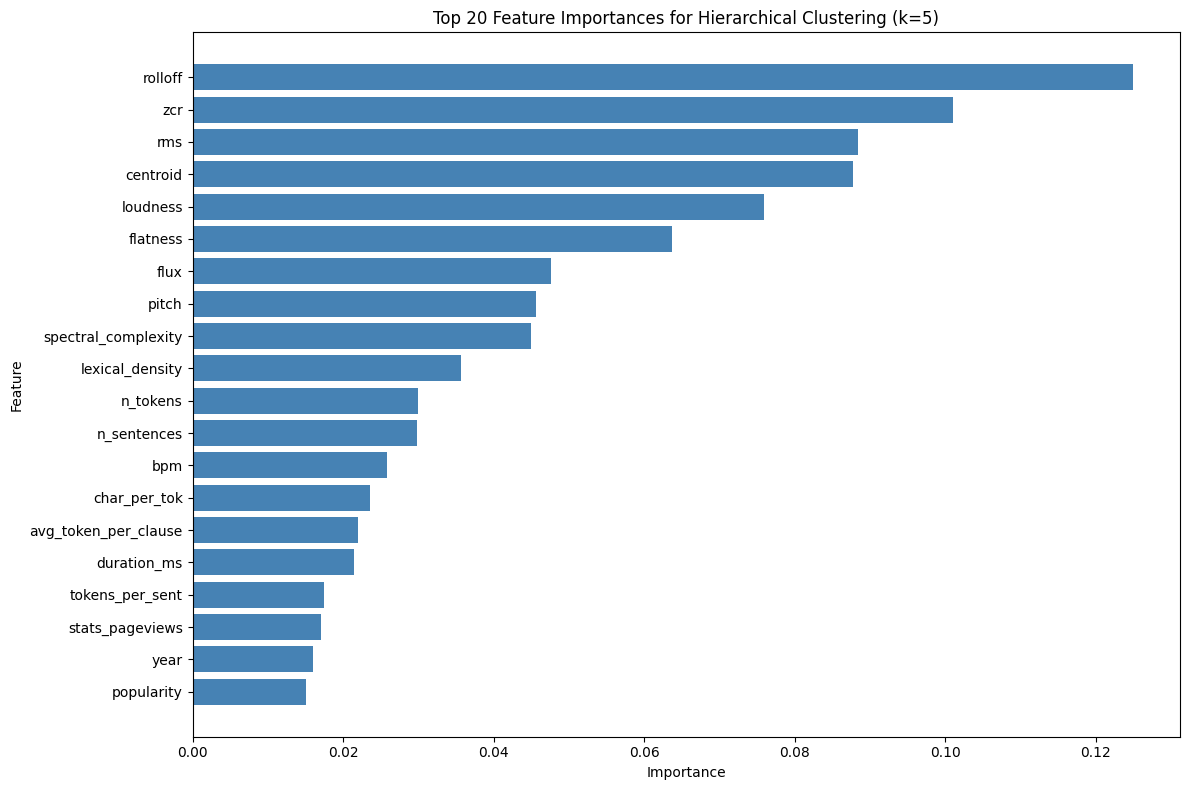

In [13]:
top_n = 20
top_features = list(feature_importances_dict.items())[:top_n]
features, importances = zip(*top_features)

plt.figure(figsize=(12, 8))
plt.barh(range(len(features)), importances, color='steelblue')
plt.yticks(range(len(features)), features)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importances for Hierarchical Clustering (k={chosen_k})')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Artists per Cluster
To validate whether the clustering makes sense, we can examine which artists belong to each cluster. This allows us to listen to the artists and verify if the clusters have meaningful musical or stylistic coherence.

In [14]:
def get_artists_per_cluster(
    original_df: pd.DataFrame,
    cluster_labels: np.ndarray,
    artist_column: str = 'name_artist',
    top_n: int = 10
) -> pd.DataFrame:
    original_df['cluster'] = cluster_labels
    
    cluster_data = {}
    for cluster_id in sorted(np.unique(cluster_labels)):
        cluster_df = original_df[original_df['cluster'] == cluster_id]
        
        # Count tracks per artist in this cluster
        artist_counts = cluster_df[artist_column].value_counts().head(top_n)
        
        # Format as "Artist (N tracks)"
        formatted_artists = [f"{artist} ({count})" for artist, count in zip(artist_counts.index, artist_counts.values)]
        
        # Pad with empty strings if less than top_n artists
        while len(formatted_artists) < top_n:
            formatted_artists.append("")
        
        cluster_data[f'Cluster {cluster_id}'] = formatted_artists
    
    df = pd.DataFrame(cluster_data)
    return df


full_og_df = pd.read_csv('../dataset/tracks.csv')
artists_df = get_artists_per_cluster(full_og_df, labels, top_n=10)
artists_df

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,Frankie hi-nrg mc (73),Gemitaiz (114),Mondo Marcio (232),Ghemon (69),M¥SS KETA (4)
1,Bassi Maestro (40),Guè (95),Guè (208),Mondo Marcio (67),Rose Villain (2)
2,Shablo (26),Tony Boy (79),Gemitaiz (189),Coez (56),Shade (2)
3,Caneda (20),Dark Polo Gang (72),Fabri Fibra (184),Dargen D’Amico (54),Noyz Narcos (2)
4,Mondo Marcio (17),Sfera Ebbasta (71),Vacca (180),Neffa (52),Roshelle (1)
5,Dargen D’Amico (14),Shiva (64),Emis Killa (165),Caparezza (51),Caparezza (1)
6,Entics (14),Vacca (63),Bassi Maestro (149),Bassi Maestro (51),Shablo (1)
7,M¥SS KETA (13),Ghali (60),Inoki (130),Achille Lauro (49),MadMan (1)
8,Emis Killa (11),Marracash (60),J-Ax (123),Skioffi (48),Achille Lauro (1)
9,Salmo (10),Fabri Fibra (58),Nerone (123),Nesli (35),Caneda (1)
